In [2]:
#meta 10/17/2020 myStudy Ch8. Collaborative Filtering
# fastai.collab parts only
# based on my08_collab_clean.ipynb

#Conclusion
#For our first non-computer vision application, we looked at recommendation systems and saw how gradient descent can learn intrinsic factors or biases about items from a history of ratings. Those can then give us information about the data. 

We also built our first model in PyTorch (more of this in the next section of the book). Let's finish our dive into the other general applications of deep learning, continuing with tabular data.

In [3]:
#hide
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

In [4]:
#hide
from fastbook import *

In [5]:
from fastai.collab import *
from fastai.tabular.all import *


# Collaborative Filtering with fast.ai

## 0. Load Data
A great dataset called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating), although we will just use a subset of 100,000 of them for our example. 

The dataset is available through the usual fastai function

In [6]:
path = untar_data(URLs.ML_100k)

In [7]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
print(ratings.shape)
ratings.head()

(100000, 4)


,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Learning the Latent Factors
There is surprisingly little difference between specifying the structure of a model (as in the last section) and learning one, since we can just use our general gradient descent approach.

Step 1 of this approach is to randomly initialize some parameters. These parameters will be a set of latent factors for each user and movie. We will have to decide how many to use.

Step 2 of this approach is to calculate our predictions. We can do this by simply taking the dot product of each movie with each user. If, for instance, the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if the movie has a lot of action or not, the product of those will be particularly high if either the user likes action movies and the movie has a lot of action in it or the user doesn't like action movies and the movie doesn't have any action in it. On the other hand, if we have a mismatch (a user loves action movies but the movie isn't an action film, or the user doesn't like action movies and it is one), the product will be very low.

Step 3 is to calculate our loss. Let's pick MSE for now, since that is one reasonable way to represent the accuracy of a prediction.

That's all we need. With this in place, we can optimize our parameters (that is, the latent factors) using stochastic gradient descent, such as to minimize the loss. At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better.

## 1. Data Prep
### 1.1 Creating the DataLoaders

In [8]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
print(movies.shape)
movies.head()

(1682, 2)


,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [9]:
ratings = ratings.merge(movies)
print(ratings.shape)
ratings.head()

(100000, 5)


,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [10]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [11]:
dls.classes

{'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...],
 'title': (#1665) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...]}

In [12]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

## 2. Model
### 2.1 Dot Product Model 
is the basis of many successful recommendation systems.  This approach to collaborative filtering is known as 
`Probabilistic matrix factorization (PMF)`

> Math: dot product: The mathematical operation of multiplying the elements of two vectors together, and then summing up the result.

#### Using fastai.collab
Create and train a collaborative filtering model by using fastai's `collab_learner`

In [13]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [14]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.954306,0.946071,00:08
1,0.877032,0.881864,00:08
2,0.741271,0.835282,00:08
3,0.585380,0.817627,00:08
4,0.479471,0.819777,00:08


The names of the layers can be seen by printing the model

In [15]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

#### 2.1.1 Interpret the Model
##### Interpreting Biases
Our model is useful as it can provide us with movie recommendations for our users.  It is also interesting to see what parameters it has discovered. The easiest to interpret are the biases. 

In [16]:
movie_bias = learn.model.i_bias.weight.squeeze() #class torch.Tensor $acvideo a better way
movie_bias.shape # expected 1665 x 1

torch.Size([1665])

Here are the movies with the highest values in the bias vector.  Looking at the learned bias tells us whether a movie is of a kind that people tend to enjoy watching.  But also, even if you don't normally enjoy detective movies, you might enjoy i.e. *LA Confidential*!

In [17]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)"]

##### Interpreting the Embeddings
It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. 

In [18]:
learn.model.i_weight.weight.shape

torch.Size([1665, 50])

##### Visualize - Representation of movies based on two strongest PCA components
There is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). If interested, check out the fast.ai course [Computational Linear Algebra for Coders](https://github.com/fastai/numerical-linear-algebra). <<img_pca_movie>> shows what our movies look like based on two of the strongest PCA components.

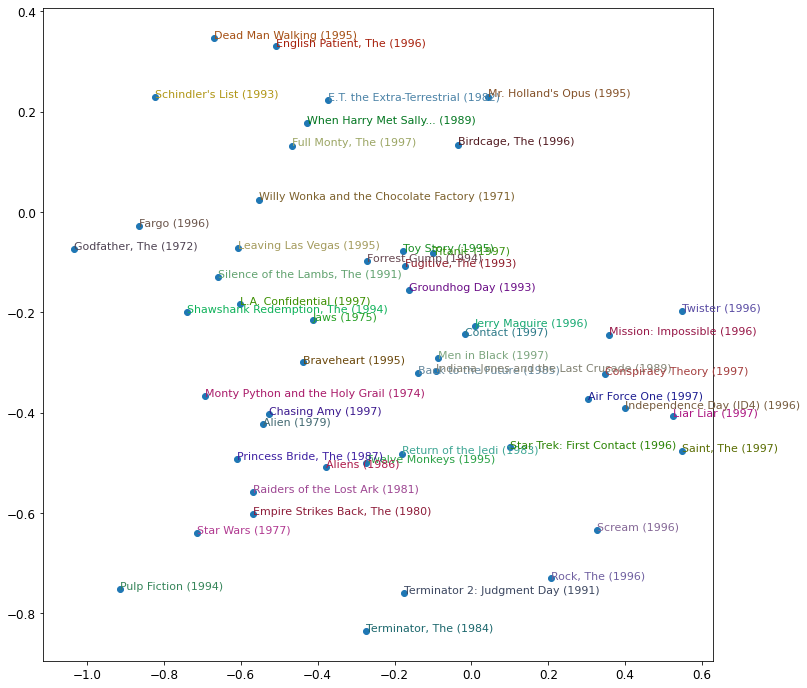

In [19]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])

#original movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_w = learn.model.i_weight.weight[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]

#plot
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

We can see here that the model seems to have discovered a concept of *classic* versus *pop culture* movies, or perhaps it is *critically acclaimed* that is represented here.

##### Embedding Distance
On a two-dimensional map we can calculate the distance between two coordinates using the formula of Pythagoras: $\sqrt{x^{2}+y^{2}}$.  
For a 50-dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.

If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical, because the users that would like them would be nearly exactly the same. There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity. We can use this to find the most similar movie to *Silence of the Lambs*:

In [20]:
movie_factors = learn.model.i_weight.weight #class torch.nn.parameter.Parameter
movie_factors.shape

torch.Size([1665, 50])

In [21]:
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Shawshank Redemption, The (1994)'

Now that we have succesfully trained a model, let's see how to deal with the situation where we have no data for a user. How can we make recommendations to new users?

##### Bootstrapping a Collaborative Filtering Model
discussion points

Our dot product model works quite well, and it is the basis of many successful real-world recommendation systems. Another approach, which generally works similarly well given the same data, is deep learning.

### 2.2 Deep Learning for Collaborative Filtering

To turn our architecture into a deep learning model, the first step is to take the results of the embedding lookup and concatenate those activations together. This gives us a matrix which we can then pass through linear layers and nonlinearities in the usual way.

Since we'll be concatenating the embedding matrices, rather than taking their dot product, the two embedding matrices can have different sizes (i.e., different numbers of latent factors). fastai has a function `get_emb_sz` that returns recommended sizes for embedding matrices for your data, based on a heuristic that fast.ai has found tends to work well in practice:

In [22]:
#from fastai.tabular.all import *
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

#### Using fastai.collab
fastai provides this model in `fastai.collab` if you pass `use_nn=True` in your call to `collab_learner` (including calling `get_emb_sz` for you), and it lets you easily create more layers. For instance, here we're creating two hidden layers, of size 100 and 50, respectively:

In [23]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.978843,0.983472,00:10
1,0.921255,0.929599,00:10
2,0.852037,0.887405,00:09
3,0.811502,0.868457,00:09
4,0.770478,0.862716,00:10


In [25]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=176, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=50, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

`learn.model` is an object of type `EmbeddingNN`. Let's take a look at fastai's code for this class:

In [24]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

Wow, that's not a lot of code! This class *inherits* from `TabularModel`, which is where it gets all its functionality from. In `__init__` it calls the same method in `TabularModel`, passing `n_cont=0` and `out_sz=1`; other than that, it only passes along whatever arguments it received.

fastai resolves this by providing a special `@delegates` decorator, which automatically changes the signature of the class or function (`EmbeddingNN` in this case) to insert all of its keyword arguments into the signature.

Although the results of `EmbeddingNN` are a bit worse than the dot product approach (which shows the power of carefully constructing an architecture for a domain), it does allow us to do something very important: we can now directly incorporate other user and movie information, date and time information, or any other information that may be relevant to the recommendation. That's exactly what `TabularModel` does. In fact, we've now seen that `EmbeddingNN` is just a `TabularModel`, with `n_cont=0` and `out_sz=1`. So, we'd better spend some time learning about `TabularModel`, and how to use it to get great results! We'll do that in the next chapter.

## Conclusion

For our first non-computer vision application, we looked at recommendation systems and saw how gradient descent can learn intrinsic factors or biases about items from a history of ratings. Those can then give us information about the data. 

We also built our first model in PyTorch (more of this in the next section of the book). Let's finish our dive into the other general applications of deep learning, continuing with tabular data.